### Задача про истребители и их поиск

На Землю нападают войска жукеров, и в их флоте присутствуют транспортники, истребители и крейсеры. Для борьбы с каждым типом кораблей используется свой вид оружия. Как аналитику из Штаба Обороны, вам поручено разработать модель, предсказывающую какие корабли участвуют в атаке, чтобы успешно отбить нападения на различные области планеты

Данных удалось собрать немного, и предсказывать придётся гораздо больший по объёму массив.

Обучите модель и предскажите классы кораблей для новых поступающих данных. Укажите в ответе через пробел число крейсеров, транспортников и истребителей.

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

%matplotlib inline

In [49]:
invasion = pd.read_csv('invasion.csv')
invasion

,class,g_reflection,i_reflection,speed,brightness,time_of_observance,volume
0,transport,2.190672,6.716633,62.168208,0.347465,158221,44.932446
1,transport,3.453276,8.995909,62.994707,0.590094,385972,41.568300
2,transport,2.432994,6.938691,62.245807,0.329288,446482,40.123467
3,fighter,6.083763,3.019459,18.474555,0.174738,210125,11.384865
4,fighter,12.876769,2.452950,195.805771,0.150446,23109,11.328806
...,...,...,...,...,...,...,...
495,fighter,9.901731,7.162124,58.095069,0.145065,395762,12.901909
496,transport,3.574132,7.118835,62.928159,0.469670,435926,39.926551
497,fighter,9.186049,4.580781,412.102112,0.108195,299594,12.178203
498,fighter,8.278256,8.353756,268.121561,0.132661,361911,13.905809


Разобьем датасэт на фичи и целевую перемененную (тип корабля)

Тип корабля разобьем на числовые значения вместо строковых (1/0)

In [50]:
X = invasion.drop('class', axis=1)
y = pd.get_dummies(invasion[['class']], columns=['class'])
y

,class_cruiser,class_fighter,class_transport
0,0,0,1
1,0,0,1
2,0,0,1
3,0,1,0
4,0,1,0
...,...,...,...
495,0,1,0
496,0,0,1
497,0,1,0
498,0,1,0


дропнем класс транспортников (очевидно, избыточная информация - если для какого-то из кораблей в первых двух классах стоит 0, значит это и есть корабль-транспортник)

In [51]:
y = y.drop('class_transport', axis=1)
y.head()

,class_cruiser,class_fighter
0,0,0
1,0,0
2,0,0
3,0,1
4,0,1


Создадим, обучим модель, а также выберем наилучшие характеристики:

In [52]:
clf = RandomForestClassifier(random_state=0)

params = {'max_depth': range(1,14,2), 'n_estimators': range(10,60,10), 
          'min_samples_leaf': range(1,8), 'min_samples_split': range(2,9,2)}

grid_search_clf = GridSearchCV(clf, params, cv=3, n_jobs=-1)

In [53]:
grid_search_clf.fit(X,y)

grid_search_clf.best_params_

{'max_depth': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 10}

In [54]:
best_clf = grid_search_clf.best_estimator_

Возьмем данные оперативной сводки, которые нужно проверить:

In [55]:
operative_inf = pd.read_csv('operative_information.csv')
operative_inf

,g_reflection,i_reflection,speed,brightness,time_of_observance,volume
0,7.516543,3.916691,513.954279,0.177247,105908,13.267224
1,4.322988,6.967689,63.752970,0.545922,277855,39.833130
2,4.595724,9.098297,62.233948,0.389201,160662,42.014556
3,2.689675,7.964869,62.475495,0.541081,162092,42.056829
4,8.075576,5.169719,336.441261,0.174757,466853,11.779813
...,...,...,...,...,...,...
1495,11.755466,5.583147,325.069957,0.170644,388400,13.210917
1496,12.220137,4.023177,439.975574,0.163958,195305,13.819358
1497,1.611053,7.864930,65.025106,0.430021,307856,47.369083
1498,7.114131,5.532188,391.178342,0.150117,51590,12.447761


In [56]:
y_pred = best_clf.predict(operative_inf)

pred_class_df = pd.DataFrame(data = y_pred, columns= ['class_cruiser', 'class_fighter'])

pred_class_df

,class_cruiser,class_fighter
0,0,1
1,0,0
2,0,0
3,0,0
4,0,1
...,...,...
1495,0,1
1496,0,1
1497,0,0
1498,0,1


In [57]:
pred_class_df.value_counts()

class_cruiser  class_fighter
0              1                675
               0                595
1              0                230
dtype: int64

это значит, что:
- транспортников 595
- истребителей 675
- крейсеров 230

Посчитаем показатели модели:

In [58]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.3, random_state=42)

In [59]:
y_test

,class_cruiser,class_fighter
361,1,0
73,0,1
374,0,1
155,0,1
104,0,1
...,...,...
266,1,0
23,0,0
222,0,1
261,1,0


In [60]:
clf = RandomForestClassifier(random_state=0)

params = {'max_depth': range(1,14,2), 'n_estimators': range(10,60,10), 
          'min_samples_leaf': range(1,8), 'min_samples_split': range(2,9,2)}

grid_search_clf = GridSearchCV(clf, params, cv=3, n_jobs=-1)

grid_search_clf.fit(X_train, y_train)

clf = grid_search_clf.best_estimator_

In [61]:
y_predicted = clf.predict(X_test)

new_pred_df = pd.DataFrame(data = y_predicted, columns= ['class_cruiser', 'class_fighter'])

new_pred_df

,class_cruiser,class_fighter
0,1,0
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
145,1,0
146,0,0
147,0,1
148,1,0


In [66]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
precision_score(y_test, new_pred_df, average= "samples", zero_division=0)

0.6266666666666667

In [63]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score



print(f'- Accuracy  (общая точность) модели равна {round(accuracy_score(y_test, new_pred_df), 3)}')

print(f'- Precision(точность с учетом ложных срабатываний) модели равна {round(precision_score(y_test, new_pred_df, average= "samples", zero_division=0), 3)}')

print(f'- Recall    (полнота верных срабатываний) модели равна {round(recall_score(y_test, new_pred_df, average= "samples", zero_division=0), 3)}')
print(f'- f1_score  (соотношение тоночти и полноты) модели равна {round(f1_score(y_test, new_pred_df, average= "samples", zero_division=0), 3)}')

- Accuracy  (общая точность) модели равна 1.0
- Precision(точность с учетом ложных срабатываний) модели равна 0.627
- Recall    (полнота верных срабатываний) модели равна 0.627
- f1_score  (соотношение тоночти и полноты) модели равна 0.627


In [64]:
feature_importances_df = pd.DataFrame({'features':list(X.columns), 
                                       'feature_importances':  best_clf.feature_importances_})\
                        .sort_values(by='feature_importances', ascending= False)

feature_importances_df

,features,feature_importances
3,brightness,0.393398
5,volume,0.247763
1,i_reflection,0.184770
2,speed,0.146114
0,g_reflection,0.027955
4,time_of_observance,0.000000


#### Ответ неверный!

вспоминаем про важность корреляции между фичами! 

        При высокой скореллированности нескольких переменных сплит по любой из них может давать одинаковый Information Gain, и выбор будет сделан случайно. То есть, важность фичей может изменяться в зависимости от выбора из равноценных в процессе обучения. 

#### Строим таблицу корреляции фичей

<AxesSubplot: >

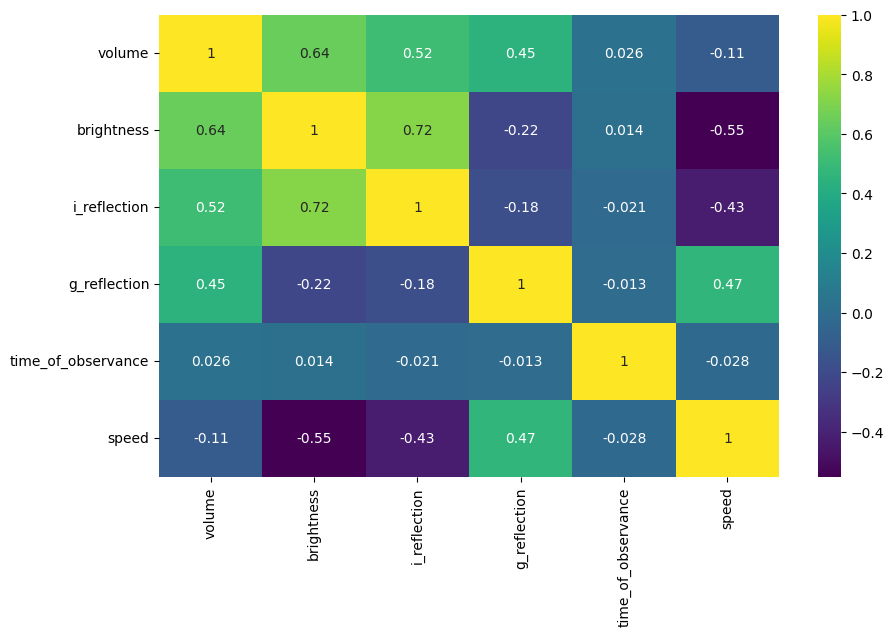

In [68]:
k = len(X.columns)      # число строк и столбцов таблицы корреляции

cols = X.corr().nlargest(k, 'volume')['volume'].index

cm = X[cols].corr()

plt.figure(figsize = (10,6))

sns.heatmap(cm, annot= True, cmap= 'viridis')


Отлично коррелируют между собой:
- блекс и i-отражение
- блеск и объем

логичным выводом напрашивается - удалить из обучающейся модели фичу блеск (brightness)

In [69]:
X = X.drop('brightness', axis =1)
X

,g_reflection,i_reflection,speed,time_of_observance,volume
0,2.190672,6.716633,62.168208,158221,44.932446
1,3.453276,8.995909,62.994707,385972,41.568300
2,2.432994,6.938691,62.245807,446482,40.123467
3,6.083763,3.019459,18.474555,210125,11.384865
4,12.876769,2.452950,195.805771,23109,11.328806
...,...,...,...,...,...
495,9.901731,7.162124,58.095069,395762,12.901909
496,3.574132,7.118835,62.928159,435926,39.926551
497,9.186049,4.580781,412.102112,299594,12.178203
498,8.278256,8.353756,268.121561,361911,13.905809


Снова подберем наилучшие параметры и обучим модель, найдем лучший классификатор:

In [70]:
clf = RandomForestClassifier(random_state=0)

params = {'max_depth': range(1,9,2), 'n_estimators': range(20,101,20), 
          'min_samples_leaf': range(1,5), 'min_samples_split': range(2,9,2)}

grid_search_clf = GridSearchCV(clf, params, cv=3, n_jobs=-1)

grid_search_clf.fit(X, y)

grid_search_clf.best_params_

{'max_depth': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 40}

In [71]:
best_clf_new = grid_search_clf.best_estimator_

In [72]:
feature_importances_df = pd.DataFrame({'features':list(X.columns), 
                                       'feature_importances':  best_clf_new.feature_importances_})\
                        .sort_values(by='feature_importances', ascending= False)

feature_importances_df

,features,feature_importances
4,volume,0.432763
1,i_reflection,0.289268
0,g_reflection,0.156764
2,speed,0.121186
3,time_of_observance,0.000020


### и вот теперь правильный ответ!!!

### Дополнительное задание:

Благодаря вашим стараниям войска захватчиков были разгромлены, но война ещё не окончена! Вас повысили и перевели на новое направление (новые должности - новые задачи) - теперь нужно выявлять опасные регионы космоса, где могут находиться жукеры.

        Проанализируйте имеющиеся данные об опасности разных регионов космоса и укажите **наиболее вероятные причины угрозы**

In [73]:
danger_space_inf = pd.read_csv('space_can_be_a_dangerous_place.csv')
danger_space_inf

,r,phi,peradventure_index,dustiness,black_hole_is_near,buggers_were_noticed,nearby_system_has_planemo,dangerous
0,169.1,138.0,22.3212,0.706285,0,1,1,1
1,11.1,148.0,1.4652,-0.410512,1,1,1,1
2,274.6,201.0,36.2472,0.756457,1,1,1,1
3,172.8,173.0,22.8096,0.035221,1,1,1,1
4,223.3,222.0,29.4756,0.197271,0,1,1,1
...,...,...,...,...,...,...,...,...
99995,301.7,249.0,39.8244,0.397064,0,1,1,1
99996,194.0,350.0,25.6080,-1.062202,0,1,1,1
99997,201.4,112.0,26.5848,1.571040,0,1,1,1
99998,7.8,115.0,1.0296,-1.206575,0,1,1,1


По сути снова задача на поиск важности фичей.

Пойдем по порядку:
1) разобьем на фичи и целеувую переменную (показатель "ОПАСНЫЙ район")
2) проверим корреляцию фичей, устраним лишние
3) обучим классификатор, найдем наилучшие параметры
4) найдем самые важные фичи

In [75]:
X= danger_space_inf.drop('dangerous', axis = 1)
y = danger_space_inf.dangerous


0        1
1        1
2        1
3        1
4        1
        ..
99995    1
99996    1
99997    1
99998    1
99999    1
Name: dangerous, Length: 100000, dtype: int64

In [78]:
danger_space_inf['dangerous'].value_counts()

1    90202
0     9798
Name: dangerous, dtype: int64

в основном опасные участки

<AxesSubplot: >

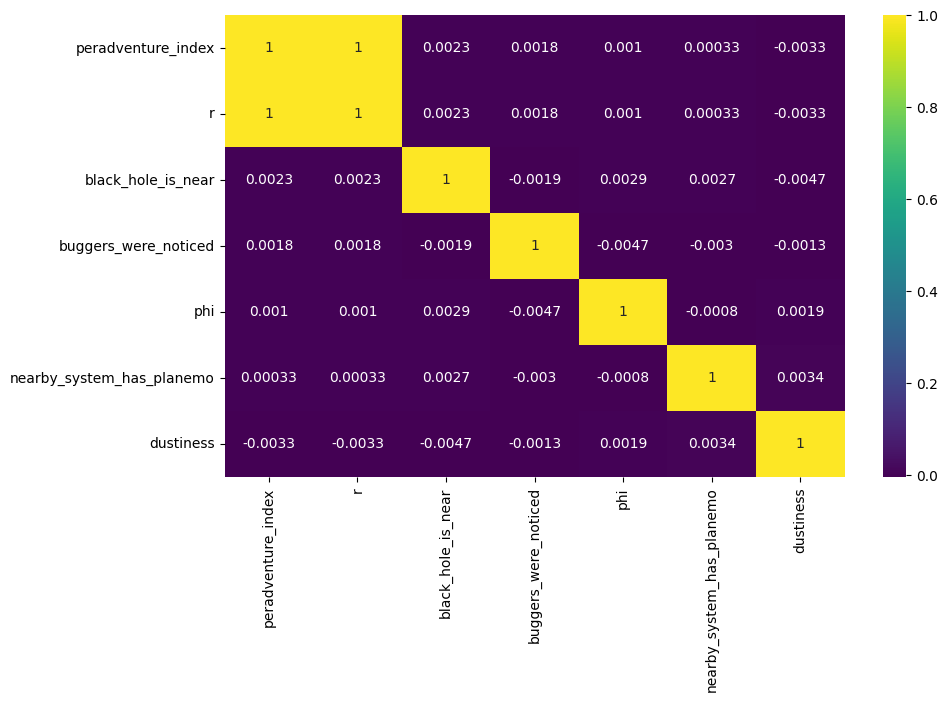

In [79]:
k = len(X.columns)      # число строк и столбцов таблицы корреляции

cols = X.corr().nlargest(k, 'r')['r'].index

cm = X[cols].corr()

plt.figure(figsize = (10,6))

sns.heatmap(cm, annot= True, cmap= 'viridis')

стопроцентная корреляция между фичами 'peradventure_index' и 'r' - дропнем последнюю

In [80]:
X = X.drop('r', axis = 1)


,phi,peradventure_index,dustiness,black_hole_is_near,buggers_were_noticed,nearby_system_has_planemo
0,138.0,22.3212,0.706285,0,1,1
1,148.0,1.4652,-0.410512,1,1,1
2,201.0,36.2472,0.756457,1,1,1
3,173.0,22.8096,0.035221,1,1,1
4,222.0,29.4756,0.197271,0,1,1
...,...,...,...,...,...,...
99995,249.0,39.8244,0.397064,0,1,1
99996,350.0,25.6080,-1.062202,0,1,1
99997,112.0,26.5848,1.571040,0,1,1
99998,115.0,1.0296,-1.206575,0,1,1


In [81]:
clf = RandomForestClassifier(random_state=0)

params = {'max_depth': range(1,9,2), 'n_estimators': range(20,101,20), 
          'min_samples_leaf': range(1,5), 'min_samples_split': range(2,9,2)}

# grid_search_clf = GridSearchCV(clf, params, cv=3, n_jobs=-1)

# grid_search_clf.fit(X, y)

# grid_search_clf.best_params_

{'max_depth': 7,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 20}

GridSearch подбирал параметры 18,5 минут! 

поверим ему на слово и просто запомним их) и не будем больше напрягать оперативку)

Лучшие параметры:

{'max_depth': 7,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 20}

In [82]:
# формируем лучший классификатор:
best_clf = RandomForestClassifier(max_depth=7, n_estimators=20, min_samples_leaf=1, min_samples_split=4,  random_state=0)

In [83]:
# обучаем лучший классификатор

best_clf.fit(X,y)

RandomForestClassifier(max_depth=7, min_samples_split=4, n_estimators=20,
                       random_state=0)

смотрим на важность фичей

In [84]:
feature_importances_df = pd.DataFrame({'features':list(X.columns), 
                                       'feature_importances':  best_clf.feature_importances_})\
                        .sort_values(by='feature_importances', ascending= False)

feature_importances_df

,features,feature_importances
4,buggers_were_noticed,0.550046
5,nearby_system_has_planemo,0.400158
3,black_hole_is_near,0.015448
2,dustiness,0.012766
1,peradventure_index,0.012043
0,phi,0.009540


Выводы: 
- Присутствие жукеров в системе - очевидный сигнал об опасности

- Наличие планемо увеличивает опасность - возможно жукеры строят свои базы на этих телах